<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span><ul class="toc-item"><li><span><a href="#Summary-of-changes" data-toc-modified-id="Summary-of-changes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Summary of changes</a></span></li><li><span><a href="#Acronyms-and-abbreviations" data-toc-modified-id="Acronyms-and-abbreviations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Acronyms and abbreviations</a></span></li><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Code setup</a></span></li></ul></li><li><span><a href="#Establish-Data-Frames" data-toc-modified-id="Establish-Data-Frames-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Establish Data Frames</a></span><ul class="toc-item"><li><span><a href="#Read-ENM-data" data-toc-modified-id="Read-ENM-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read ENM data</a></span></li><li><span><a href="#ENM-dataframes" data-toc-modified-id="ENM-dataframes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ENM dataframes</a></span></li><li><span><a href="#ENM-WF-bins" data-toc-modified-id="ENM-WF-bins-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ENM WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#Preliminary-performance-check" data-toc-modified-id="Preliminary-performance-check-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preliminary performance check</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span><ul class="toc-item"><li><span><a href="#Similarity-heatmap" data-toc-modified-id="Similarity-heatmap-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Similarity heatmap</a></span></li><li><span><a href="#Dendrograms-and-elbow-graph" data-toc-modified-id="Dendrograms-and-elbow-graph-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Dendrograms and elbow graph</a></span></li><li><span><a href="#Helper-class-for-selecting-best-ENM-estimator" data-toc-modified-id="Helper-class-for-selecting-best-ENM-estimator-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Helper class for selecting best ENM estimator</a></span></li><li><span><a href="#Gridsearch-to-select-n_clusters" data-toc-modified-id="Gridsearch-to-select-n_clusters-3.4.4"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>Gridsearch to select n_clusters</a></span></li><li><span><a href="#Apply-feature-agglomeration-using-optimized-n_clusters" data-toc-modified-id="Apply-feature-agglomeration-using-optimized-n_clusters-3.4.5"><span class="toc-item-num">3.4.5&nbsp;&nbsp;</span>Apply feature agglomeration using optimized n_clusters</a></span></li><li><span><a href="#Concatenate-final-dataframe" data-toc-modified-id="Concatenate-final-dataframe-3.4.6"><span class="toc-item-num">3.4.6&nbsp;&nbsp;</span>Concatenate final dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Core-models" data-toc-modified-id="Core-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Core models</a></span><ul class="toc-item"><li><span><a href="#Clustering,-regression-Model" data-toc-modified-id="Clustering,-regression-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Clustering, regression Model</a></span></li><li><span><a href="#PCA,-regression-Model" data-toc-modified-id="PCA,-regression-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PCA, regression Model</a></span></li><li><span><a href="#Compare-feature-predictivity" data-toc-modified-id="Compare-feature-predictivity-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Compare feature predictivity</a></span></li><li><span><a href="#NEW-ENM-Model-(Clusters)" data-toc-modified-id="NEW-ENM-Model-(Clusters)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>NEW ENM Model (Clusters)</a></span></li><li><span><a href="#NEW-ENM-Model-(PCA)" data-toc-modified-id="NEW-ENM-Model-(PCA)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>NEW ENM Model (PCA)</a></span></li></ul></li></ul></div>

# Intro

## Summary of changes

##### Changes since 12/05/18:
* Made binning function more efficient
* Put clustering code into functions

## Acronyms and abbreviations

* arr = array
* bp = boiling point
* cv = cross validation
* df = data frame
* enm = engineered nanomaterials
* matrix_F = matrix of the product is a formulation (i.e., not an article)
* mp = melting point
* mw = molecular weight
* oecd = Organisation for Economic Co-operation and Development
* prop = property
* puc = product use category
* rbf = radial basis function (a non-linear implementation of SVM)
* rfc = random forest classifier
* svc = support vector classifier (for categorical data)
* svm = support vector machine
* wf = weight fraction

## Code setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To suppress warning output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys

In [2]:
# To make this notebook's output stable across runs
np.random.seed(24)

In [3]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#np.set_printoptions(precision=3, suppress=True)

In [4]:
# Saving figures
import os

#os.chdir(path)
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "BLTfigs"

if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

# Function to save figures as pdfs
def savepdf(fig, name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf', 
                   bbox_inches='tight')

Figure directory exists.


In [5]:
# To enable a specified sound to play
from IPython.display import Audio
sound_file = './data/Glass.wav'

# Option to play sound at the end of a function with a long run time
Audio(url=sound_file, autoplay=True)

In [6]:
# Shift tab to understand function components
# Type questionmark before function to bring up help

# Establish Data Frames

## Read ENM data

In [7]:
# Read in engineered nanomaterials (ENM) weight fraction data and 
# potential predictive variables
X_enm = pd.read_csv("./data/ENM_conc_export.csv", sep=',', header='infer')

# Drop unwanted columns
    # For PUC, keeping getcat, group, refined, assigned ("matrix")
    # Drop dehydrating_agent[22],dispersing_agent[24],fuel_agent[27]
X_enm.drop(X_enm.columns[[0,1,2,3,4,9,12,22,24,27,34,35,36]], 
           axis=1, inplace=True)

# Rename PUC columns
X_enm.rename(columns = {'gencatID':'gen'}, inplace = True)
X_enm.rename(columns = {'refined_product_type':'refined'}, inplace = True)
X_enm.rename(columns = {'assignedID':'matrix'}, inplace = True)

In [8]:
# Find and replace (clean data)

# To maintain atomicity, assign all child-specific products (C) as articles (A) 
# and all OTC pharmaceuticals (P) as formulas (F) (they were all liquids)
X_enm['matrix'] = X_enm['matrix'].replace('C','A', regex=True)
X_enm['matrix'] = X_enm['matrix'].replace('P','F', regex=True)
#list(X_enm.assigned.values)

# Clean up data in refined column so it's only spray vs NOC
X_enm['refined'] = X_enm['refined'].replace('child','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('exterior','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('interior','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('soft','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('plastic','NOC', regex=True)

# Rename functions to match organics dataset
X_enm.rename(columns = {'antistain_agent':'antiredeposition_agent'}, 
             inplace = True)
X_enm.rename(columns = {'lubricating_agent':'anti_adhesive_cohesive'}, 
             inplace = True)

# Move anti_adhesive_cohesive column up in order
cols = X_enm.columns.tolist()
cols = cols[:9]+[cols[-4]]+cols[9:20]+cols[21:]
X_enm = X_enm[cols]

In [9]:
# Transform factor data (product categories) into binary columns
X_enm=pd.get_dummies(X_enm, 
                     prefix=["gen","group","refined","matrix"], 
                     columns=["gen","group","refined","matrix"])

# Remove spaces from column names
X_enm.columns = X_enm.columns.str.replace(' ','')
X_enm.columns = X_enm.columns.str.replace('/','')
X_enm.columns = X_enm.columns.str.replace('-','')

In [10]:
# Drop columns absent from organics
X_enm.drop(['gen_AP','gen_CS','gen_FC','gen_PH','group_apparel',
            'group_coldrelief','group_firstaid','group_foodstorage',
            'group_largeappliances','group_nutritionalsupplements',
            'group_portableairprocessing','group_toys',
            'refined_NOC','matrix_A'], 
           axis=1, inplace=True)

In [11]:
# Export column headings list
cols = X_enm.columns.tolist()
with open('./data/2018-10-31_final-headers.txt', 'w') as filehandle:  
    for listitem in cols:
        filehandle.write('%s\n' % listitem)
cols

['propMW',
 'propMP',
 'propBP',
 'propDensity',
 'absorbent',
 'anti_adhesive_cohesive',
 'antioxidant',
 'antiredeposition_agent',
 'biocide',
 'brightener',
 'chemical_reaction_regulator',
 'colorant',
 'deodorizer',
 'filler',
 'flavouring_nutrient',
 'hardener',
 'humectant',
 'opacifier',
 'uv_stabilizer',
 'viscosity_modifier',
 'gen_AC',
 'gen_CP',
 'gen_EL',
 'gen_HM',
 'gen_PC',
 'gen_PE',
 'gen_VE',
 'group_childspecific',
 'group_dentalcare',
 'group_deodorant',
 'group_enginemaintenance',
 'group_fabrictreatmentanddye',
 'group_facialcleansingandmoisturizing',
 'group_fungicide',
 'group_generalhouseholdcleaning',
 'group_generalmoisturizing',
 'group_makeupandrelated',
 'group_paintstainandrelatedproducts',
 'group_sunscreen',
 'group_surfacesealers',
 'refined_spray',
 'matrix_F']

In [12]:
# Log-transform density so that it is no longer skewed
X_enm['propLogDensity'] = X_enm['propDensity'].apply(np.log10)

# Replace propDensity with propLogDensity in data frame
cols = X_enm.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[4:-1]
X_enm = X_enm[cols]

In [13]:
# Export entire feature dataframe (pre-processing)
X_enm.to_csv('./data/X_enm_preproc.csv')
X_enm.head(4)

,propMW,propMP,propBP,propLogDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,79.867,1843.00,2972.0,0.626340,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,63.546,1083.00,2567.0,0.952308,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,65.370,419.53,907.0,0.853698,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,107.868,961.78,2162.0,1.014730,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [14]:
# Read in ENM maximum_weight_fraction data
y_enm = pd.read_csv("./data/ENM_conc_export.csv", sep=',', 
                    header='infer', usecols=[3])
# As array
yarr_enm = np.array(y_enm.maximum_weight_fraction)
print(yarr_enm.shape)

(82,)


## ENM dataframes

Split ENM-WF into separate dataframes.

In [15]:
# Dataframe for ENM function and product categories
Xfp_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xfp_enm.drop(Xfp_enm.columns[0:4], axis=1, inplace=True) # drop chem props
enm_all_names=list(Xfp_enm.columns.values)

In [16]:
# Dataframe for only ENM functional use categories
Xf_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xf_enm.drop(Xf_enm.columns[0:4], axis=1, inplace=True) # drop chem props
Xf_enm.drop(Xf_enm.columns[16:], axis=1, inplace=True) # drop PUC

# Column names
enm_func_names=list(Xf_enm.columns.values)

# Export dataframe
#Xf_enm.to_csv('./data/Xf_enm.csv')

In [17]:
# Dataframe for only ENM product categories
Xp_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xp_enm.drop(Xp_enm.columns[0:20], axis=1, inplace=True)
Xp_enm.drop(Xp_enm.columns[20:], axis=1, inplace=True) # drop matrix categories
enm_PUC_names=list(Xp_enm.columns.values)

# Export dataframe
Xp_enm.to_csv('./data/Xp_enm.csv')

In [18]:
# Array for only chemical properties
Xc_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xc_enm.drop(Xc_enm.columns[4:], axis=1, inplace=True)
list(Xc_enm.columns.values)

['propMW', 'propMP', 'propBP', 'propLogDensity']

In [19]:
# Dataframe for only ENM [product] matrix categories
Xm_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xm_enm.drop(Xm_enm.columns[0:40], axis=1, inplace=True)
list(Xm_enm.columns.values)

['refined_spray', 'matrix_F']

## ENM WF bins

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  3., 12., 13., 16.,  4.,  2.,  2.,
         5.,  6.,  7.,  1.,  6.,  0.,  3.]),
 array([-5.00000000e+00, -4.75021824e+00, -4.50043648e+00, -4.25065472e+00,
        -4.00087296e+00, -3.75109120e+00, -3.50130944e+00, -3.25152768e+00,
        -3.00174592e+00, -2.75196416e+00, -2.50218240e+00, -2.25240064e+00,
        -2.00261888e+00, -1.75283712e+00, -1.50305536e+00, -1.25327360e+00,
        -1.00349184e+00, -7.53710085e-01, -5.03928325e-01, -2.54146565e-01,
        -4.36480540e-03]),
 <a list of 20 Patch objects>)

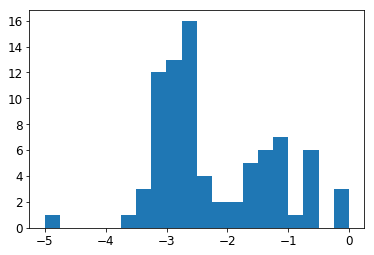

In [20]:
# Log-transformed histogram of weight fraction
plt.hist(np.log10(np.asarray(y_enm)), bins=20)

In [21]:
# Define function to assign weight fractions to bins 
# (slightly different ranges from those used by Isaacs et al. 2016)
def bins(row):
    if row['maximum_weight_fraction'] <= 0.002:
        val = 0 # low
    elif row['maximum_weight_fraction'] > 0.05:
        val = 2 # high
    else:
        val = 1 # medium
    return val

# Apply bins to ENM and organics data
bin_enm = np.asarray(y_enm.apply(bins, axis=1))

In [22]:
# Define function to view wf bin distributions
def bar_graph_bins(label_data,
                   data_composition):
    """
    This function creates a bar graph of weight
    fraction bins and prints the count and frequency 
    for each.
    
    Parameters
    ----------
    label_data: int array of shape [n,]
        Dataframe containing binned wf data
    data_composition: string
        Describes the chemical composition of label_data 
        for use in the plot title; e.g., `ENM`, `Organics`
        
    """
    # Find the count, frequency of WF bins
    unique, counts = np.unique(label_data, return_counts=True)
    wf_distrib = dict(zip(unique, counts))
    freq = []
    for i in counts:
        percent = (i/np.sum(counts)).round(2)
        freq.append(percent)

    # Plot
    plt.bar(range(len(wf_distrib)), list(wf_distrib.values()), align='center')
    plt.xticks(range(len(wf_distrib)), list(['low','medium','high']))
    plt.title('Frequency of %s Weight Fraction Bins' % data_composition)
    plt.show()
    
    print('Label bin: ', unique)
    print('Count    : ', counts)
    print('Frequency: ', freq)

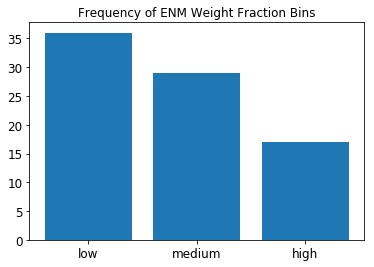

Label bin:  [0 1 2]
Count    :  [36 29 17]
Frequency:  [0.44, 0.35, 0.21]


In [23]:
# View bar plot of ENM WF bins
bar_graph_bins(bin_enm, data_composition='ENM')

# Pre-processing

## Data distributions

In [24]:
# Function for plotting piecharts
def plot_piechart(data,
                  labels, 
                  save_fig_name):
    my_colors = ["#1f77b4","#ff7f0e","#ffdf00","#d62728","#9467bd",
                 "#2ca02c","#1034A6","#ffbf33","#8B0000",'teal',
                 "#aada30","#e37799","#17becf","#7f7f7f","#cc0099","#0B6623"]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(data, autopct='%1.1f%%', 
           colors=my_colors, 
           labels=labels, 
           pctdistance=0.9, labeldistance=1.05, 
           startangle=90, counterclock=False, 
           textprops={'fontsize':9})
    ax.axis('equal')
    ax.set_title(save_fig_name, weight="bold")
    fig.savefig('./BLTfigs/pie_%s.png' 
                % save_fig_name.lower().replace(' ','_'))
    plt.show()

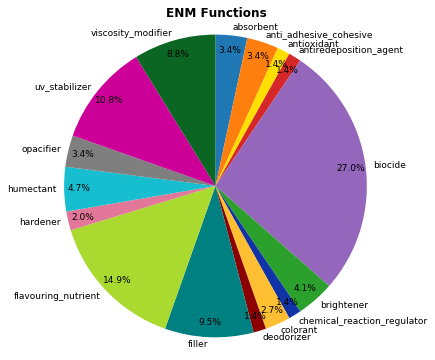

In [25]:
# ENM function breakdown as pie chart
plot_piechart(data=Xf_enm.sum(axis=0), 
              labels=enm_func_names, 
              save_fig_name='ENM Functions')

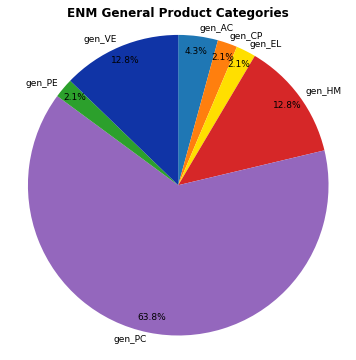

In [26]:
# ENM PUC breakdown as pie chart
plot_piechart(data=Xp_enm.values[:,0:7].sum(axis=0), 
              labels=enm_PUC_names[0:7], 
              save_fig_name='ENM General Product Categories')

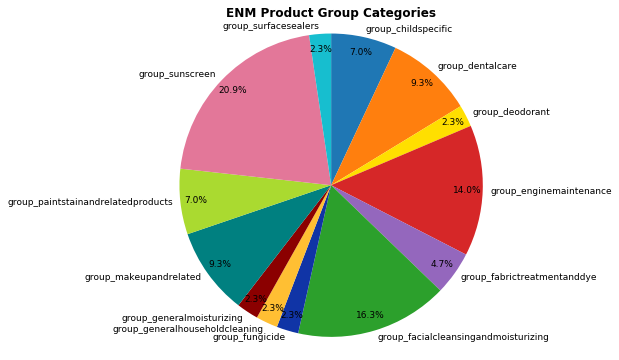

In [27]:
# ENM PUC breakdown as pie chart
plot_piechart(data=Xp_enm.values[:,7:].sum(axis=0), 
              labels=enm_PUC_names[7:], 
              save_fig_name='ENM Product Group Categories')

In [28]:
# General product categories vs product group categories
PUC_sums = pd.DataFrame([Xp_enm.iloc[:,:7].sum(axis=1), 
                         Xp_enm.iloc[:,7:].sum(axis=1)]).T
cols = ['sum_gen', 'sum_group']
PUC_sums.columns = cols
PUC_sums.head(10)

,sum_gen,sum_group
0,1,1
1,0,0
2,0,0
3,1,1
4,1,1
5,1,0
6,1,0
7,0,0
8,0,0
9,0,0


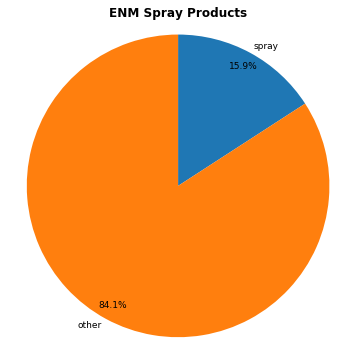

In [29]:
# ENM PUC breakdown as pie chart
labels = ['spray','other']
values = [(np.count_nonzero(X_enm['refined_spray'])), 
          (len(X_enm['refined_spray']) - np.count_nonzero(X_enm['refined_spray']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='ENM Spray Products')

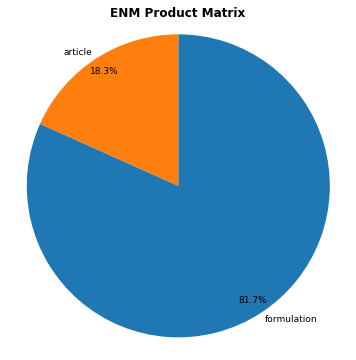

In [30]:
# ENM product matrices as pie chart
labels = ['formulation','article']
values = [(np.count_nonzero(X_enm['matrix_F'])), 
          (len(X_enm['matrix_F']) - np.count_nonzero(X_enm['matrix_F']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='ENM Product Matrix')

## Preliminary performance check

Have to run fit with [X + a very small number] so that features with very few ones don't go missing during cross validation. https://stats.stackexchange.com/questions/324732/kernel-density-estimator-kde-with-too-many-zeroes-as-input

In [35]:
# TODO: breaks on contour plot when search includes third parameter

# Define function to optimize and perform SVC-RBF with all features
# (normalized), accuracy scoring
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.svm import SVR
import random

def gridsearch_svm(X_training, 
                   y_training, 
                   n_clusters_set=None, 
                   c_set=np.logspace(-1,8,24), 
                   gamma_set=np.logspace(-8,1,24), 
                   plot_contour=False):
    """
    This function searches the specified grid of C and gamma values for the 
    optimal parameter values with which to run SVC-RBF, then returns the best 
    values based on validation accuracy. 
    
    Parameters
    ----------
    n_clusters_set: array of int (default=None)
        Includes feature agglomeration in pipeline using the specified array of
        cluster numbers to try out
    plot_contour: bool (default=False)
        `True` will plot accuracy as contour lines on the 
        specified parameter grid.
        
    """ 
    
    # Define pipelines and parameters for the grid search
    seed = random.randint(1,100)
    if isinstance(y_training[0], float):
        estimator = SVR(kernel='rbf')
        scoring = 'explained_variance'
    else:
        estimator = SVC(kernel='rbf', 
                        class_weight='balanced', 
                        random_state=seed)
        scoring = 'accuracy'
    if np.all(n_clusters_set == None):
        prepipe = Pipeline([('scale', MinMaxScaler()), 
                            ('estimator', estimator)
                           ])
        param_grid = {'estimator__C': c_set,
                      'estimator__gamma': gamma_set
                     }
    else:
        agg = FeatureAgglomeration(X_training, 
                                   affinity="cosine", 
                                   linkage="average")
        prepipe = Pipeline([('agg', agg), 
                            ('estimator', estimator)
                           ])
        param_grid = {'agg__n_clusters': n_clusters_set, 
                      'estimator__C': c_set, 
                      'estimator__gamma': gamma_set
                     }

    # Grid search with CV to find best model parameters
    n_jobs = 3
    grid_search = GridSearchCV(prepipe, 
                               param_grid, 
                               cv=10, 
                               scoring=scoring, 
                               n_jobs=n_jobs, 
                               pre_dispatch=2*n_jobs)
    grid_search.fit(X_training, y_training)
    C = grid_search.best_params_.get('estimator__C')
    gamma = grid_search.best_params_.get('estimator__gamma')
    print(grid_search.best_params_)
    print('K-fold CV random state: ', seed)
    print('Best fold',grid_search.scoring, ':    ',grid_search.best_score_)
    
    # Optional contour plot
    if plot_contour:
        test_scores = np.reshape(grid_search.cv_results_.get('mean_test_score'), 
                                 newshape=[-1, len(gamma_set)])
        fig = plt.figure()
        plt.contour(np.log10(gamma_set), 
                    np.log10(c_set), 
                    test_scores)
        plt.title('Accuracy over parameter grid')
        plt.xlabel('log_10(gamma)')
        plt.ylabel('log_10(C)')
        plt.colorbar()
        plt.show()
    
    # Play sound when done running
    display(Audio(url=sound_file, autoplay=True))
    
    return C, gamma

{'estimator__C': 448925.12582186074, 'estimator__gamma': 1e-08}
K-fold CV random state:  92
Best fold explained_variance :     0.035715593846593466


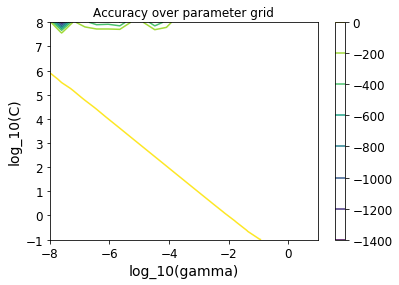

(448925.12582186074, 1e-08)

In [36]:
# Continuous WF, all features
gridsearch_svm(X_training=X_enm, 
               y_training=np.log10(np.asarray(y_enm)).ravel(), 
               plot_contour=True)

{'estimator__C': 6700187.50350959, 'estimator__gamma': 6.061898993497573e-08}
K-fold CV random state:  27
Best fold accuracy :     0.6341463414634146


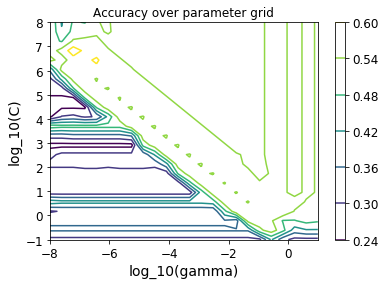

(6700187.50350959, 6.061898993497573e-08)

In [37]:
# WF bins, all features
gridsearch_svm(X_training=X_enm, 
               y_training=bin_enm,
               plot_contour=True)

{'estimator__C': 4961.947603002908, 'estimator__gamma': 5.484416576121026e-06}
K-fold CV random state:  9
Best fold accuracy :     0.6219512195121951


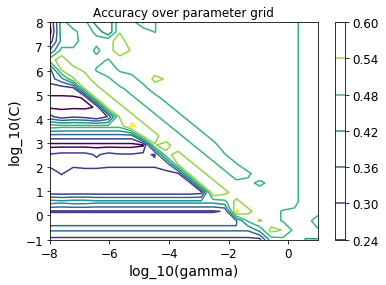

(4961.947603002908, 5.484416576121026e-06)

In [41]:
# WF bins, functions only
gridsearch_svm(X_training=Xf_enm, 
               y_training=bin_enm,            
               plot_contour=True)

{'estimator__C': 0.6061898993497574, 'estimator__gamma': 0.670018750350959}
K-fold CV random state:  20
Best fold accuracy :     0.573170731707317


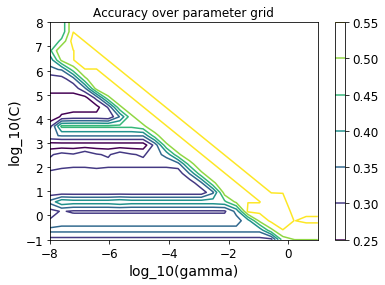

(0.6061898993497574, 0.670018750350959)

In [38]:
# WF bins, PUC only
gridsearch_svm(X_training=Xp_enm, 
               y_training=bin_enm,            
               plot_contour=True)

{'estimator__C': 3.67466194073669, 'estimator__gamma': 0.11052951411260221}
K-fold CV random state:  89
Best fold accuracy :     0.5853658536585366


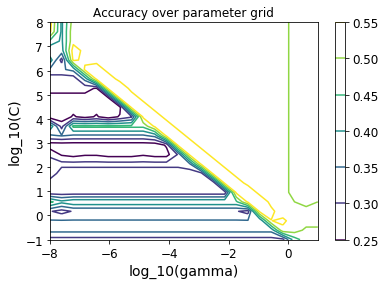

(3.67466194073669, 0.11052951411260221)

In [44]:
# WF bins, general product use categories only
gridsearch_svm(X_training=Xp_enm.iloc[:,7:], 
               y_training=bin_enm,          
               plot_contour=True)

## PCA

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

***TODO: Add in cross-validation***

In [45]:
# Scale the data first (i.e., chemical properties) so everything is from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_enm_scaled = scaler.fit_transform(X_enm)

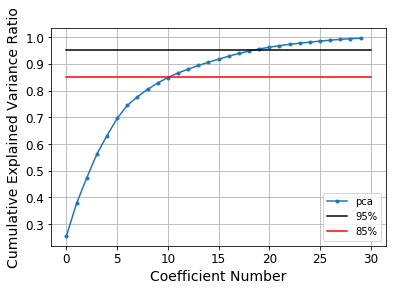

In [46]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=30)
dim_red_enm=pca.fit(X_enm_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 30],[.95,.95],'k',label='95%')
plt.plot([0, 30],[.85,.85],'r',label='85%')
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

In [49]:
# Transform/apply PCA
from sklearn import decomposition 
pca = decomposition.PCA(n_components=19)
dim_red_enm = pd.DataFrame(pca.fit_transform(X_enm_scaled))

# Export PCA dataframe
dim_red_enm.to_csv("./data/PCA_enm.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

## Hierarchical Agglomerative Clustering (HAC)

* Feature Agglomeration sklearn http://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html
* Alternate approach
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
* Distance matrix with Jaccard similarity: https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity

### Similarity heatmap

In [60]:
# Function for distance matrix, selecting n_clusters
from scipy.spatial.distance import squareform, pdist, cosine, jaccard
from scipy.cluster.hierarchy import dendrogram, linkage

def distance_heatmap(feature_data, 
                       feature_names, 
                       save_fig_name, 
                       dist_metric='cosine'):
    
    # Transform to find distance between features (not datapoints)
    distance = pdist(feature_data.T, dist_metric)
    
    # Make matrix
    dist_matrix = pd.DataFrame(squareform(distance), 
                                   index=feature_names, 
                                   columns=feature_names)
    
    # Plot matrix
    from textwrap import wrap
    #fig, ax = plt.subplots(1,1)
    fig = plt.imshow(dist_matrix)
    plt.title("\n".join(wrap('%s\nDistance Matrix of Features (%s)' 
                             % (dist_metric.title(), 
                                save_fig_name.title()), 60)))
    #plt.yticks(feature_names)#, rotation='horizontal')
    #fig.set_yticklabels(feature_names)#, rotation='horizontal')
    plt.colorbar()
    plt.savefig('./BLTfigs/enm_distancematrix_%s_%s.png' 
                % (save_fig_name, dist_metric))

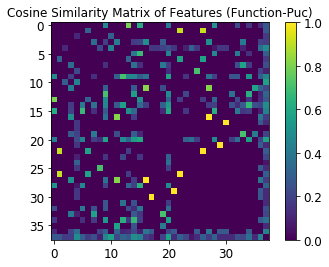

In [54]:
# Similarity matrix
# ENM Function and PUC features
similarity_heatmap(Xfp_enm, 
                   feature_names=enm_all_names, 
                   save_fig_name='function-PUC')

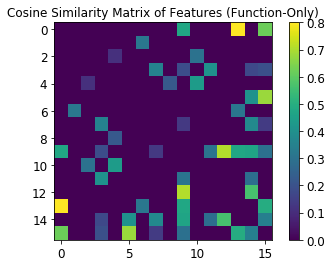

In [55]:
# Similarity matrix
# ENM Function features
similarity_heatmap(Xf_enm, 
                   feature_names=enm_func_names, 
                   save_fig_name='function-only')

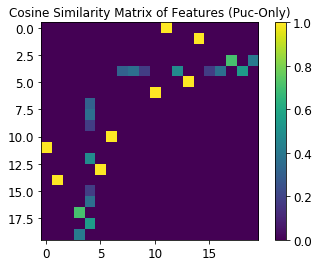

In [56]:
# Similarity matrix
# ENM PUC features
similarity_heatmap(Xp_enm, 
                   feature_names=enm_PUC_names, 
                   save_fig_name='PUC-only')

### Dendrograms and elbow graph

Optimize the number of clusters using the elbow method, which estimates the clustering step where the acceleration of distance growth is largest (indicated by the dashed gray line on the dendrogram).

In [55]:
# Define function to visualize best parameter options for clustering
from scipy.spatial.distance import pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

def optimize_clustering(feature_data,
                        feature_names,
                        save_fig_name):
    
    # Calculate cosine distance and features to be clustered 
    # Z-array has format [idx1, idx2, dist, sample_count]
    Z = linkage((feature_data.T), method='average', metric='cosine')
    
    # Calculations for elbow graph
    last = Z[-len(Z):, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    
    # Find the 5 best contenders for optimal n_clusters
    n = acceleration_rev.argmax() + 2  # if idx 0 is the max, want 2 clusters
    top_n_clusters = acceleration_rev.argsort()[::-1][:5] + 2
    
    # Calculate best clustering threshold for dendrogram
    cutoff_idx = len(feature_data.T) - n - 1
    cutoff_dist = Z[cutoff_idx,2]
    
    # Report optimal n_clusters with Elbow Method
    plt.plot(idxs, last_rev, label='distance')
    plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
    plt.title('Elbow Method to Determine n_clusters for %s Features' 
              % save_fig_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
    plt.savefig('./BLTfigs/enm_elbow_%s.png' % save_fig_name)
    plt.show()

    print("Optimal(?) n_clusters:", n)   
    print("Contending n_clusters:", top_n_clusters)
    
    # Plot and save dendrogram
    fig=plt.figure(figsize=(30, 15))
    plt.title('Hierarchical Clustering Dendrogram (%s)' % save_fig_name)
    plt.xlabel('Feature Index')
    plt.ylabel('Distance')
    dendrogram(Z,
               leaf_rotation=90.,  # rotates the x axis labels
               leaf_font_size=14.,  # font size for the x axis labels
               labels=feature_names)
    plt.axhline(y=cutoff_dist, color='gray', linestyle='--',
               label="cluster threshold")
    plt.show()
    savepdf(fig,'enm_cluster_dendrogram_%s' % save_fig_name)
    
    return top_n_clusters

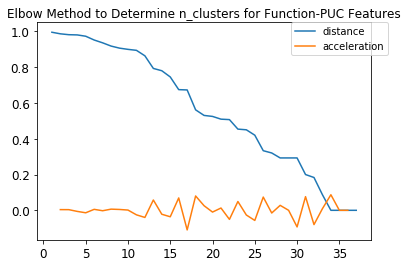

Optimal(?) n_clusters: 34
Contending n_clusters: [34 18 31 26 16]


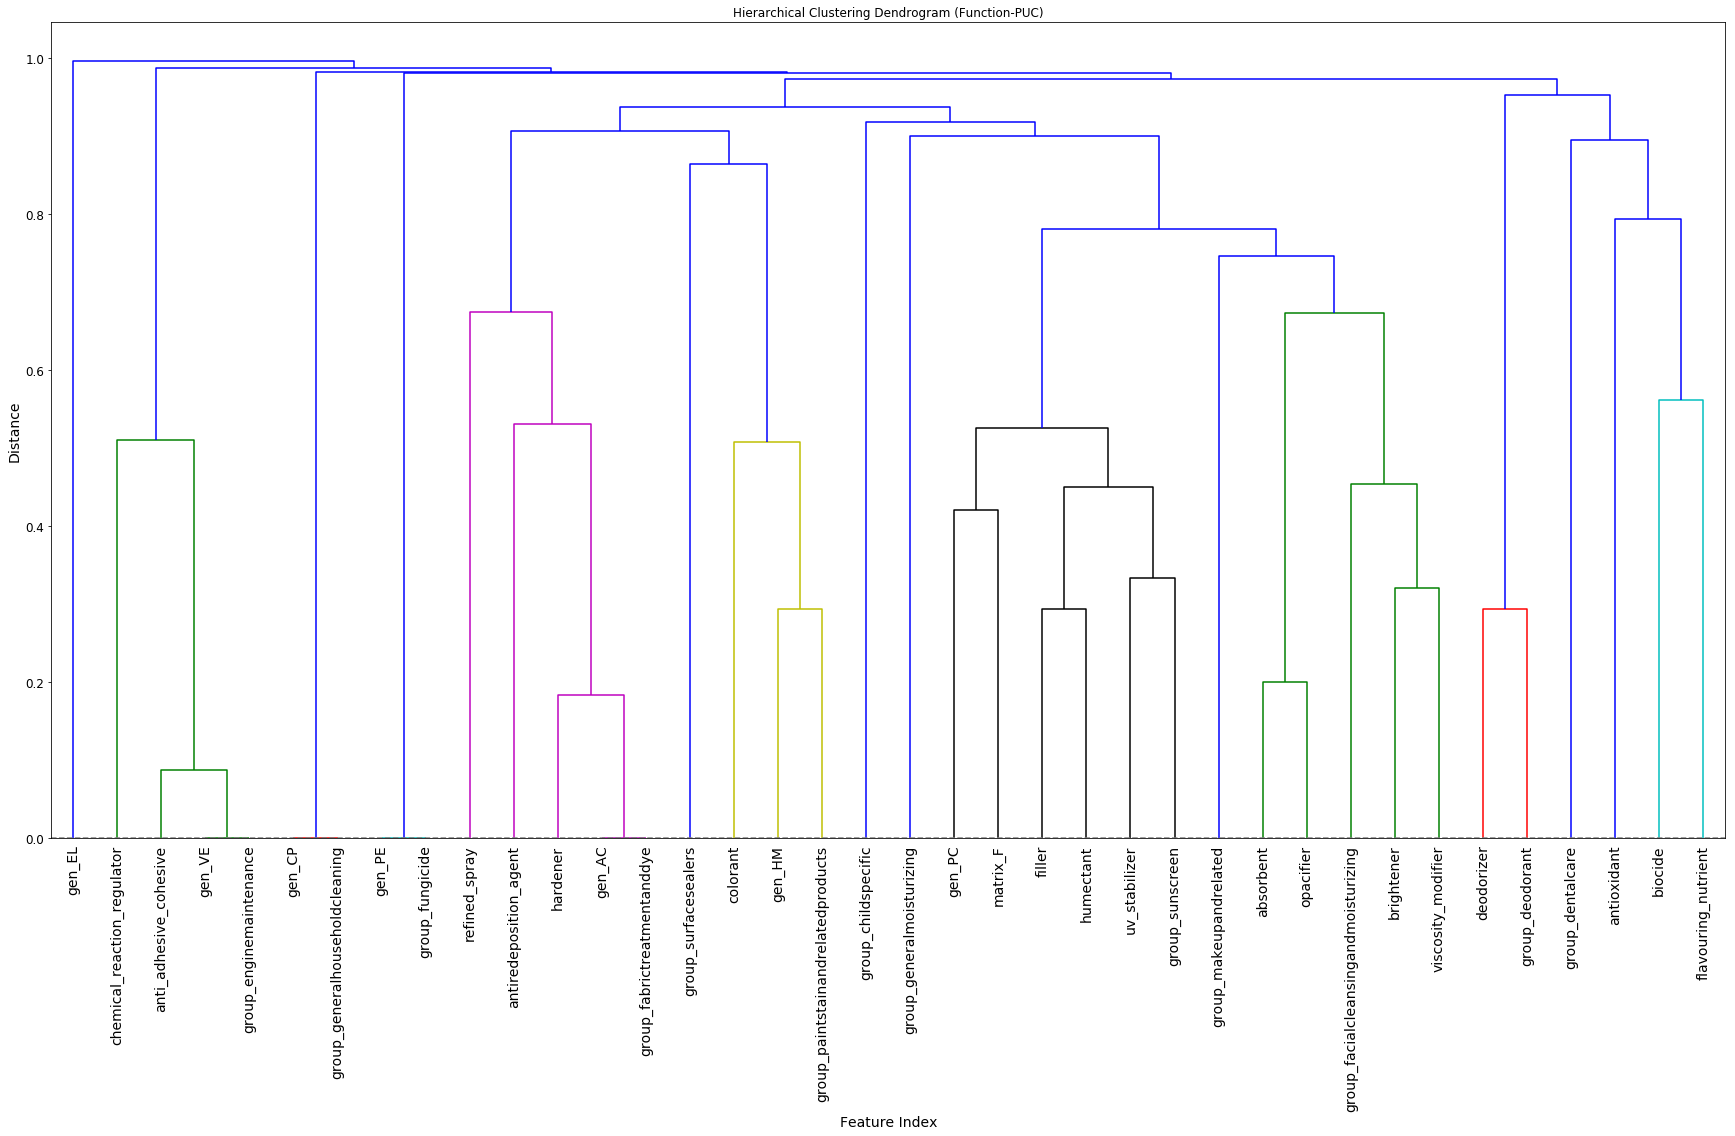

array([34, 18, 31, 26, 16])

In [57]:
# Similarity matrix
# ENM Function and PUC features
optimize_clustering(Xfp_enm, 
                    feature_names=enm_all_names, 
                    save_fig_name='Function-PUC')

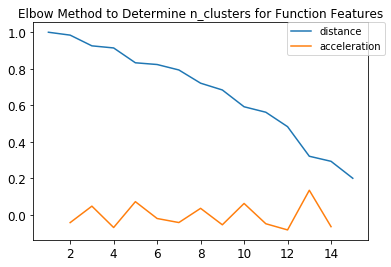

Optimal(?) n_clusters: 13
Contending n_clusters: [13  5 10  3  8]


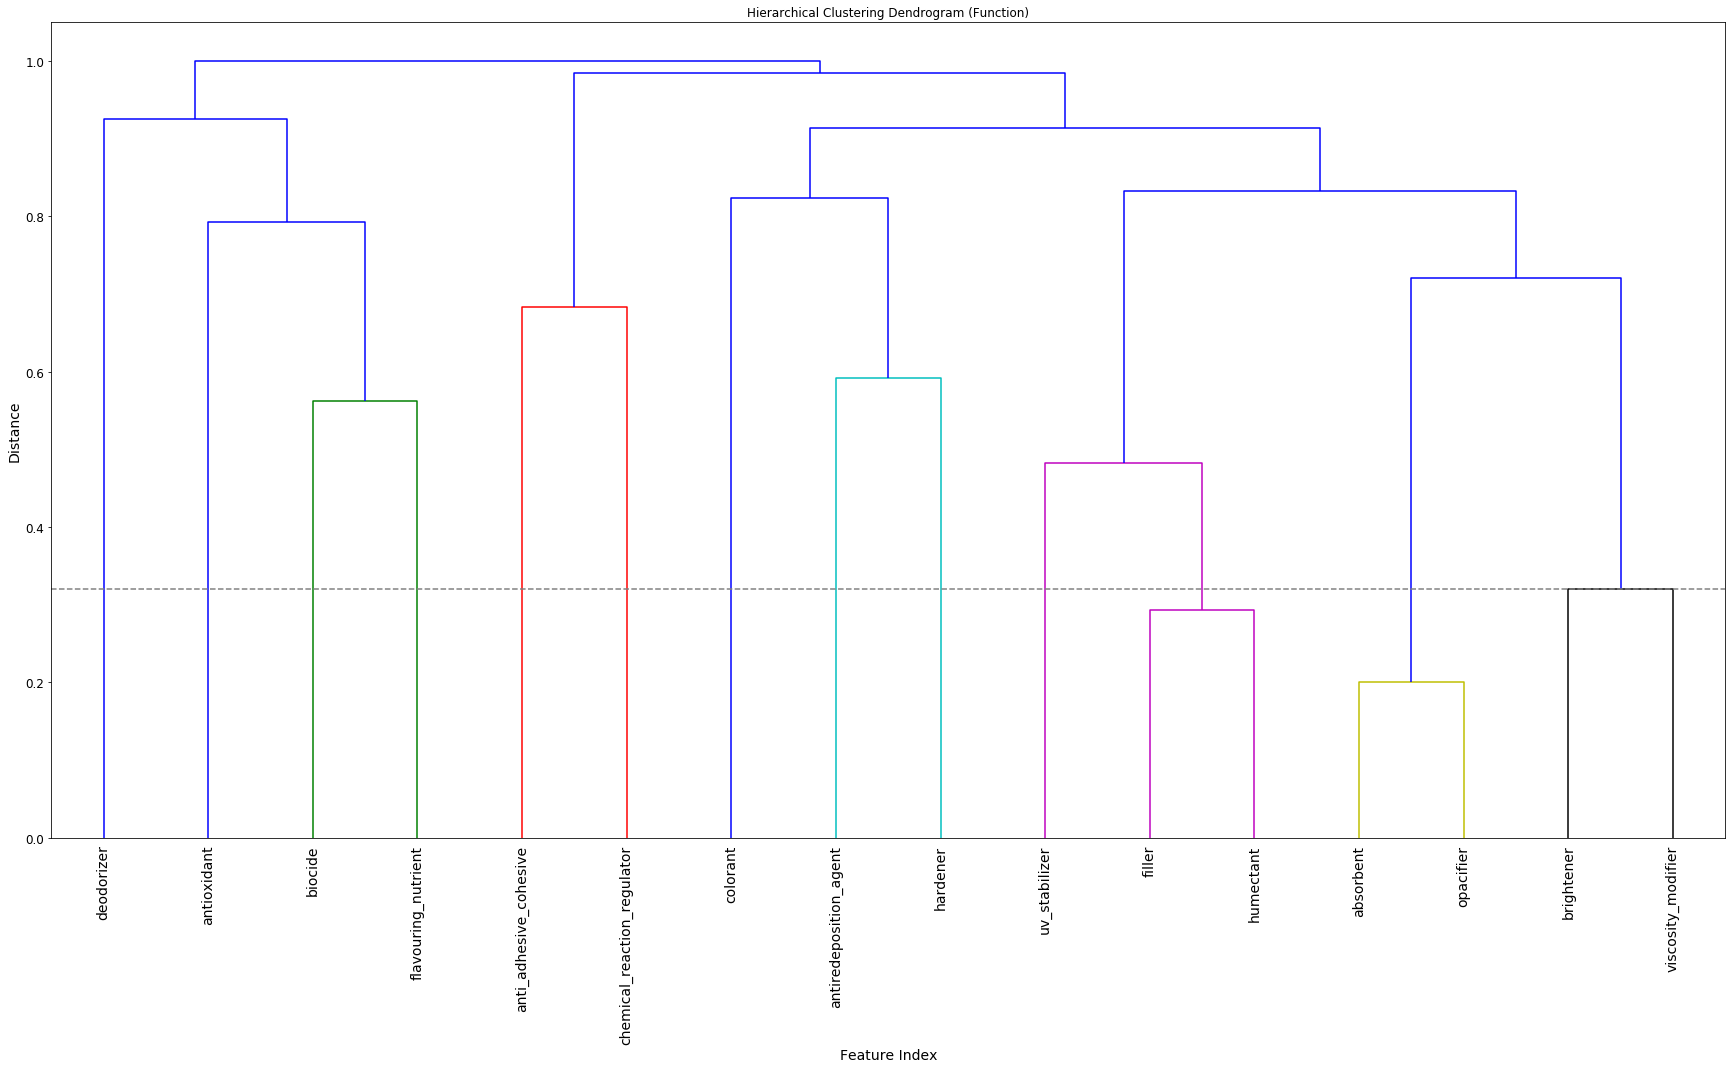

In [58]:
# Elbow graph and dendrogram
# ENM functions only
cluster_set_f = optimize_clustering(Xf_enm, 
                                    feature_names=enm_func_names, 
                                    save_fig_name='Function')

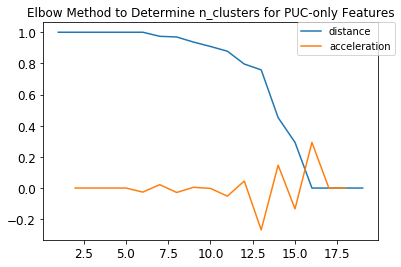

Optimal(?) n_clusters: 16
Contending n_clusters: [16 14 12  7  9]


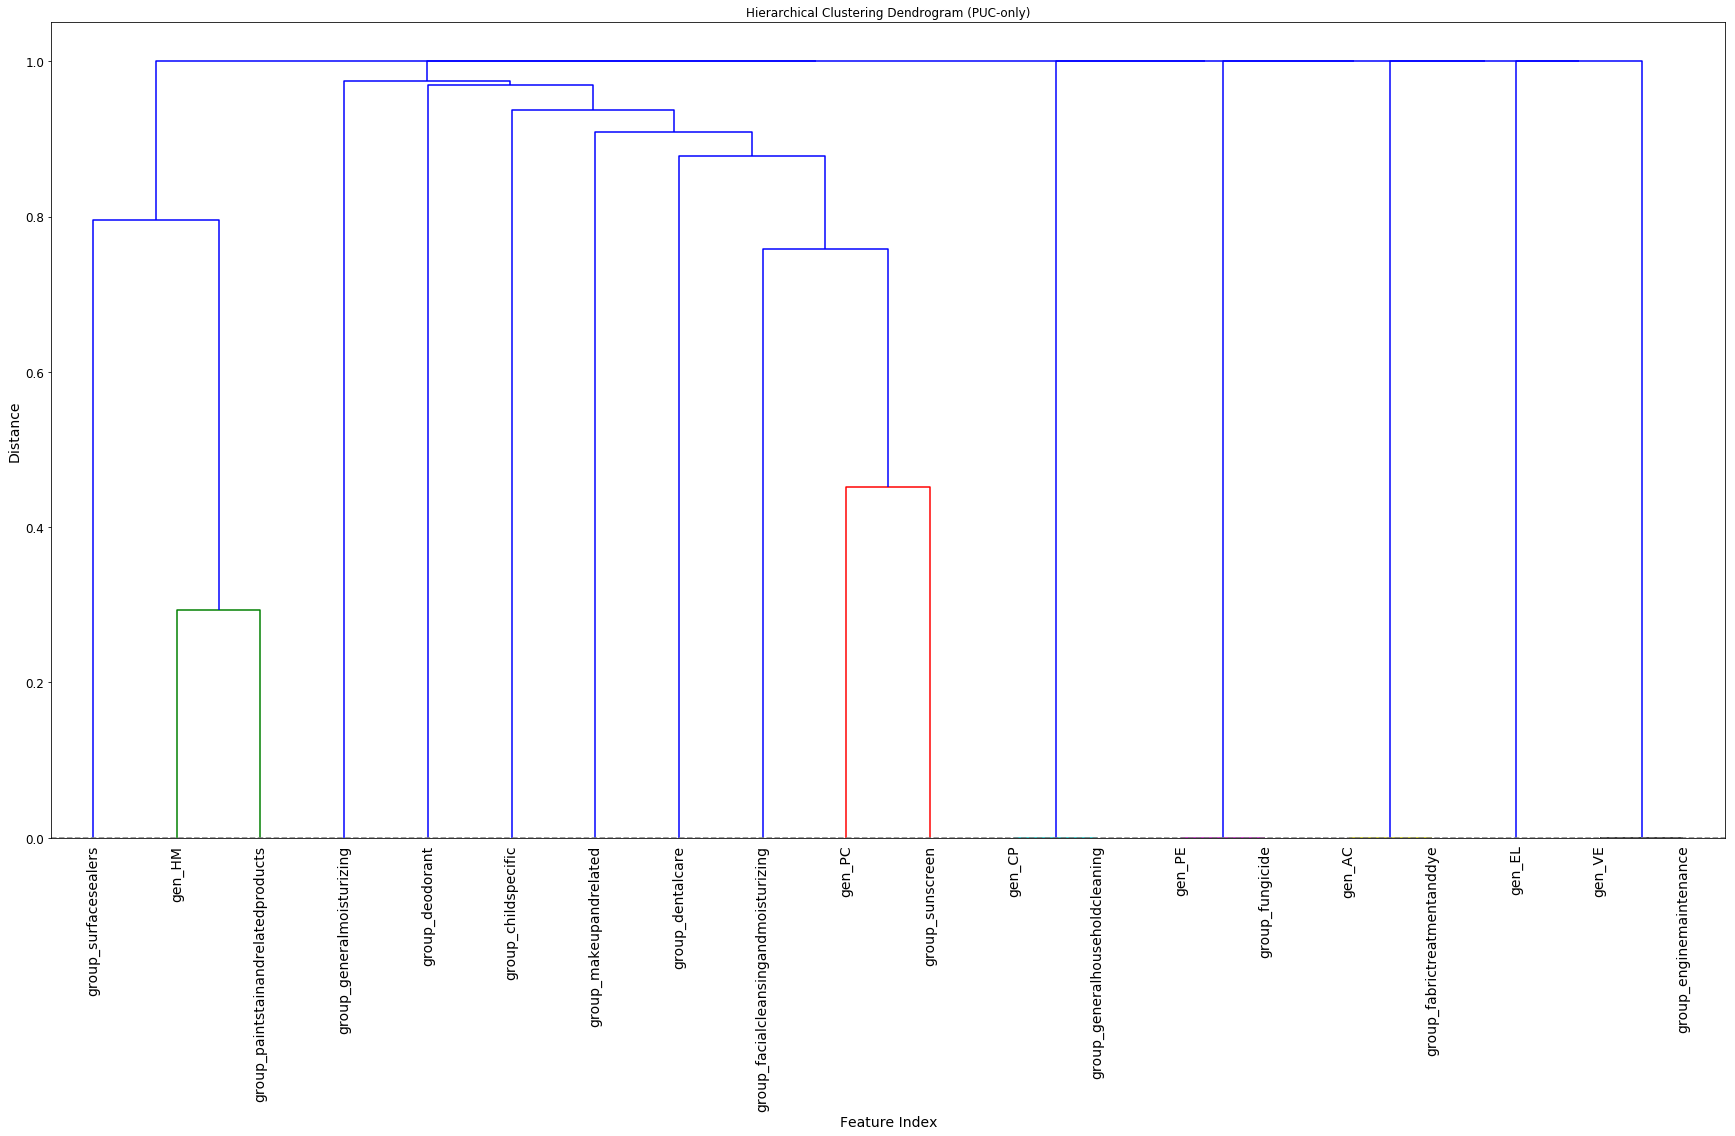

In [72]:
# Elbow graph and dendrogram
# ENM PUC features
cluster_set_p = optimize_clustering(Xp_enm, 
                                    feature_names=enm_PUC_names, 
                                    save_fig_name='PUC-only')

### Helper class for selecting best ENM estimator

Estimator Selection Helper by David Batista
http://www.davidsbatista.net/blog/2018/02/23/model_optimization/

In [75]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=10
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='accuracy', refit=False): # scoring=None
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [210]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=5
models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}
params = {
    'RandomForest': { 'n_estimators': [4,8,12,16,20]},
    'SVC': [{'kernel': ['linear'], 
             'C': np.logspace(-1,7,9)},
            {'kernel': ['rbf'], 
             'C': np.logspace(-1,7,9), 
             'gamma': np.logspace(-7,1,9)},
           ]
}

In [211]:
# Fit gridsearch models to select best estimator based on accuracy
# Function features only
helper = EstimatorSelectionHelper(models, params)
helper.fit(Xf_enm+0.0001, bin_enm, n_jobs=3)
helper.score_summary(sort_by='mean_score')

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Running GridSearchCV for SVC.
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.5s finished


RandomForest
SVC


[Parallel(n_jobs=3)]: Done 900 out of 900 | elapsed:   16.9s finished
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
38,SVC,0.333333,0.638492,1,0.227326,10,0.1,rbf,NaN
54,SVC,0.333333,0.624206,0.888889,0.20781,1000,0.001,rbf,NaN
78,SVC,0.333333,0.624206,0.888889,0.20781,1e+06,1e-06,rbf,NaN
62,SVC,0.333333,0.624206,0.888889,0.20781,10000,0.0001,rbf,NaN
46,SVC,0.333333,0.624206,0.888889,0.20781,100,0.01,rbf,NaN
70,SVC,0.333333,0.624206,0.888889,0.20781,100000,1e-05,rbf,NaN
77,SVC,0.444444,0.610714,1,0.189917,1e+06,1e-07,rbf,NaN
37,SVC,0.444444,0.610714,1,0.189917,10,0.01,rbf,NaN
53,SVC,0.444444,0.610714,1,0.189917,1000,0.0001,rbf,NaN
61,SVC,0.444444,0.610714,1,0.189917,10000,1e-05,rbf,NaN


In [212]:
# Fit gridsearch models to select best estimator
# PUC features only
helper.fit(Xp_enm+0.0001, bin_enm, n_jobs=3)
helper.score_summary(sort_by='mean_score')

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Running GridSearchCV for SVC.
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Done 900 out of 900 | elapsed:    1.5s finished


RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
30,SVC,0.333333,0.607143,0.857143,0.151138,1,1,rbf,NaN
84,SVC,0.333333,0.596032,0.857143,0.150436,1e+06,1,rbf,NaN
48,SVC,0.333333,0.596032,0.857143,0.150436,100,1,rbf,NaN
93,SVC,0.333333,0.596032,0.857143,0.150436,1e+07,1,rbf,NaN
57,SVC,0.333333,0.596032,0.857143,0.150436,1000,1,rbf,NaN
66,SVC,0.333333,0.596032,0.857143,0.150436,10000,1,rbf,NaN
75,SVC,0.333333,0.596032,0.857143,0.150436,100000,1,rbf,NaN
39,SVC,0.333333,0.596032,0.857143,0.150436,10,1,rbf,NaN
85,SVC,0.333333,0.590476,0.857143,0.152835,1e+06,10,rbf,NaN
49,SVC,0.333333,0.590476,0.857143,0.152835,100,10,rbf,NaN


The best performing classifier for both data subsets was the SVC-RBF. This will be used in subsequent pre-processing steps.

### Gridsearch to select n_clusters

The top few n_clusters found using elbow graphs in addition to the maximum number of clusters (i.e., no agglomeration), are evaluated using an SVC-RBF (supervised learning) to determine the final n_clusters. This is done using the gridsearch function defined under preliminary performance evaluation.

In [213]:
# Function features only
gridsearch_svm(Xf_enm+0.0001, 
               bin_enm, 
               n_clusters_set=np.append(cluster_set_f, len(Xf_enm.columns)), 
               c_set=np.logspace(-1,7,20), 
               gamma_set=np.logspace(-7,1,20))

{'agg__n_clusters': 13, 'estimator__C': 12.742749857031335, 'estimator__gamma': 0.004281332398719396}
K-fold CV random state:  87
Best fold accuracy :     0.6341463414634146


(12.742749857031335, 0.004281332398719396)

In [214]:
# PUC features only
gridsearch_svm(Xp_enm+0.0001, 
               bin_enm, 
               n_clusters_set=np.append(cluster_set_p, len(Xp_enm.columns)), 
               c_set=np.logspace(-1,7,20), 
               gamma_set=np.logspace(-7,1,20))

{'agg__n_clusters': 16, 'estimator__C': 0.6951927961775606, 'estimator__gamma': 0.5455594781168515}
K-fold CV random state:  53
Best fold accuracy :     0.573170731707317


(0.6951927961775606, 0.5455594781168515)

In [59]:
Xf_enm

,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,chemical_reaction_regulator,colorant,deodorizer,filler,flavouring_nutrient,hardener,humectant,opacifier,uv_stabilizer,viscosity_modifier
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1
1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


### Apply feature agglomeration using optimized n_clusters

A more conservative approach to feature agglomeration was taken. Only features with almost...........

In [283]:
# Apply feature agglomeration
# PUC features only
from sklearn.cluster import FeatureAgglomeration

agg = FeatureAgglomeration(n_clusters=16, affinity="cosine", linkage="average")
agg.fit(Xp_enm+0.0001)
Xp_enm_red = pd.DataFrame(agg.transform(Xp_enm))
cols_Xp_red = [
    'agg_PE_fungicide', #0
    'agg_CP_generalhouseholdcleaning', #1
    'agg_VE_enginemaintenance', #2
    'agg_AC_fabrictreatmentanddye', #3
    'group_paintstainandrelatedproducts', #4
    'group_surfacesealers', #5
    'group_facialcleansingandmoisturizing', #6
    'group_generalmoisturizing', #7    
    'group_deodorant', #8
    'group_childspecific', #9
    'group_makeupandrelated', #10
    'group_dentalcare', #11
    'group_sunscreen', #12
    'gen_EL', #13
    'gen_PC', #14
    'gen_HM', #15    
    ]
Xp_enm_red.columns = cols_Xp_red
cols_Xp_red.sort()
Xp_enm_red = Xp_enm_red[cols_Xp_red]

### Concatenate final dataframe

In [284]:
#Xp_enm = pd.DataFrame(Xp_enm)
#Xp_enm.columns = enm_PUC_names

In [286]:
# Concatenate all clustered and unscaled features into new dataframe
XX_enm = pd.concat([Xc_enm, Xf_enm, Xp_enm_red, Xm_enm], axis=1)
XX_enm.tail(4)

,propMW,propMP,propBP,propLogDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_dentalcare,group_deodorant,group_facialcleansingandmoisturizing,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
78,81.370,1975.00,2360.0,0.748576,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
79,60.085,1600.00,2230.0,0.413551,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
80,79.867,1843.00,2972.0,0.626340,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
81,107.868,961.78,2162.0,1.014730,0,0,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [287]:
# Export unscaled ENM dataframe
XX_enm.to_csv("./data/XX_enm.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

In [116]:
# Scale pchem properties
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xc_enm_scaled = scaler.fit_transform(Xc_enm)
Xc_enm_scaled = pd.DataFrame(data=Xc_enm_scaled)

In [117]:
# Concatenate all clustered and scaled features into new (alternate) dataframe
XX_enm_scaled = pd.concat([Xc_enm_scaled,Xf_enm_red,Xp_enm,Xm_enm], axis=1)
XX_enm_scaled.loc[0:3,]
#XX_scaled=np.array(XX_scaled)
#print(XX_scaled.shape)

,0,1,2,3,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_make-upandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,0.159910,0.728168,0.611018,0.082634,0.5001,0.0001,0.0001,0.0001,0.0001,1.0001,...,0,0,0,0,0,1,0,0,0,1
1,0.078351,0.387819,0.502819,0.321179,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0,0,0,0,0,0,0,0,0,1
2,0.087466,0.090699,0.059336,0.229392,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0,0,0,0,0,0,0,0,0,1
3,0.299836,0.333533,0.394619,0.391028,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,1,0,0,0,0,0,0,0,0,1


# Core models

## Clustering, regression Model

In [118]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

njobs=3
models = {
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR()
}
params = {
    'RandomForest': { 'n_estimators': [4, 8, 12, 16] },
    'SVR': [
        {'kernel': ['linear'], 'C': [1, 10, 30]},
        {'kernel': ['rbf'], 'C': [1, 5, 10, 20, 30, 40, 50], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
    ]
}


In [119]:
# Fit gridsearch models to select best estimator

helper = EstimatorSelectionHelper(models, params)
helper.fit(XX_enm_scaled+0.0001, np.log10(yarr_enm), n_jobs=n_jobs, scoring='explained_variance') # n_jobs=1 by default

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Running GridSearchCV for SVR.
Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Done 380 out of 380 | elapsed:    0.5s finished


In [120]:
# Compare performance for estimators
helper.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
37,SVR,-0.62249,0.029433,0.468392,0.25752,50,0.0001,rbf,NaN
13,SVR,-0.620176,0.0294046,0.466755,0.256595,5,0.001,rbf,NaN
32,SVR,-0.494288,0.0283195,0.397619,0.209997,40,0.0001,rbf,NaN
27,SVR,-0.377818,0.026185,0.311364,0.162786,30,0.0001,rbf,NaN
22,SVR,-0.24717,0.0219887,0.216835,0.109803,20,0.0001,rbf,NaN
17,SVR,-0.12556,0.0135234,0.125604,0.0590009,10,0.0001,rbf,NaN
8,SVR,-0.125132,0.0134843,0.125293,0.0588247,1,0.001,rbf,NaN
12,SVR,-0.060599,0.00886199,0.0731525,0.0313175,5,0.0001,rbf,NaN
7,SVR,-0.0117708,0.00211383,0.0158261,0.00645745,1,0.0001,rbf,NaN
9,SVR,-1.22213,-0.00198798,0.597689,0.446432,1,0.01,rbf,NaN


## PCA, regression Model

In [121]:
# Fit gridsearch models to select best estimator

helper2 = EstimatorSelectionHelper(models, params)
helper2.fit(dim_red_enm, np.log10(yarr_enm), n_jobs=n_jobs, scoring='explained_variance') # n_jobs=1 by default

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Running GridSearchCV for SVR.
Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Done 380 out of 380 | elapsed:    0.5s finished


In [122]:
# Compare performance for estimators
helper2.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
32,SVR,-0.498523,0.0321473,0.416344,0.2158,40,0.0001,rbf,NaN
37,SVR,-0.62239,0.0317421,0.47422,0.260206,50,0.0001,rbf,NaN
13,SVR,-0.621387,0.0317064,0.473894,0.259846,5,0.001,rbf,NaN
27,SVR,-0.374299,0.0291626,0.328704,0.16597,30,0.0001,rbf,NaN
22,SVR,-0.247183,0.0255942,0.2301,0.113148,20,0.0001,rbf,NaN
17,SVR,-0.127033,0.0149769,0.129502,0.0606043,10,0.0001,rbf,NaN
8,SVR,-0.1266,0.0148968,0.128834,0.0603578,1,0.001,rbf,NaN
12,SVR,-0.0612442,0.00999065,0.0759484,0.0324261,5,0.0001,rbf,NaN
7,SVR,-0.0118853,0.00246785,0.0173036,0.0068765,1,0.0001,rbf,NaN
9,SVR,-1.21769,0.00236644,0.588368,0.447092,1,0.01,rbf,NaN


In [123]:
# Pipeline/GridSearch to find best optimized model
# after selecting ideal estimator

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=[30,35,40,35]
gamma_set=[0.00003,0.0001,0.0003,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(XX,y_log)
grid_search.fit(dim_red_enm+.0001,np.log10(yarr_enm))
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 40, 'estimator__gamma': 0.0003}
0.016344596124322503


## Compare feature predictivity

In [50]:
# SVR-RBF with WF bins
    # Function features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-1,7,17)
gamma_set=np.logspace(-7,1,17)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xf_enm+0.0001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 3.1622776601683795, 'estimator__gamma': 0.1}
0.6463414634146342


In [51]:
# SVR-RBF with WF bins
    # Product category features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-1,7,17)
gamma_set=np.logspace(-7,1,17)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xp_enm+0.0001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1.0, 'estimator__gamma': 1.0}
0.5975609756097561


In [52]:
# SVR-RBF with WF bins
    # Chemical property features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-1,7,17)
gamma_set=np.logspace(-7,1,17)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xc_enm+0.0001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 31.622776601683793, 'estimator__gamma': 1.0}
0.5975609756097561


In [53]:
# SVR-RBF with WF bins
    # Product matrix features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-1,7,17)
gamma_set=np.logspace(-7,1,17)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xm_enm+0.0001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1.0, 'estimator__gamma': 1.0}
0.4878048780487805


## NEW ENM Model (Clusters)

In [124]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(XX_enm,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 61.584821106602604, 'estimator__gamma': 0.012742749857031322}
0.6219512195121951
accuracy


Essentially leave one out cross validation, slight biases, might be overfitting

In [125]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', C=61.584821, gamma=0.01274275))
     ])

In [126]:
# Make a confusion matrix to summarize accuracy across labels
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [127]:
from sklearn import model_selection
kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True)
cnf_matrix2=np.zeros([3,3])
X=np.array(XX_enm)
y=np.array(bin_enm)
for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);

In [128]:
cnf_matrix=cnf_matrix2.astype(np.int)

Confusion matrix, without normalization
[[29  2  5]
 [11 15  3]
 [ 3  2 12]]
Normalized confusion matrix
[[0.81 0.06 0.14]
 [0.38 0.52 0.1 ]
 [0.18 0.12 0.71]]


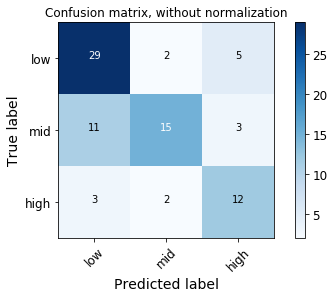

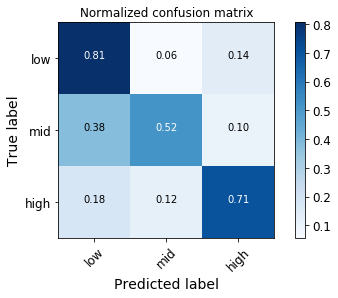

In [129]:
# Define confusion matrix
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## NEW ENM Model (PCA)

In [159]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
#    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(dim_red_enm,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 0.37926901907322497, 'estimator__gamma': 0.11288378916846883}
0.5975609756097561


In [132]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', C=0.379269, gamma=0.112884))
     ])
bestpipe.fit(dim_red_enm,bin_enm)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=0.379269, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.112884, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [133]:
from sklearn import model_selection
kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True)
cnf_matrix2=np.zeros([3,3])
X=np.array(XX_enm)
y=np.array(bin_enm)
for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);

In [134]:
cnf_matrix=cnf_matrix2.astype(np.int)

Confusion matrix, without normalization
[[31  4  1]
 [13 13  3]
 [ 5  6  6]]
Normalized confusion matrix
[[0.86 0.11 0.03]
 [0.45 0.45 0.1 ]
 [0.29 0.35 0.35]]


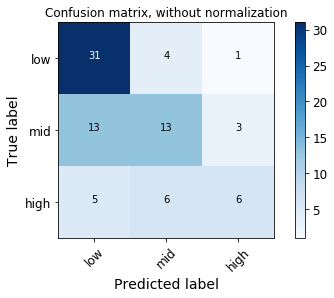

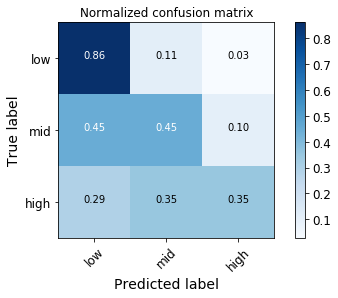

In [135]:
# Define confusion matrix
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [153]:
# TODO: correlation matrix of features vs 
enm_corr = pd.concat(XX_enm,y_enm.apply(np.log10(), axis=1)) #np.log10(yarr_enm)
plt.matshow(enm_corr.corr())

ValueError: invalid number of arguments